## Summary

---

## Imports

In [ ]:
import os
import tempfile
import urllib.request
from datetime import datetime
from pathlib import Path

import dotenv
import elaspic2 as el2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import torch
from kmbio import PDB
from kmtools import structure_tools
from tqdm.auto import tqdm

## Parameters

In [ ]:
NOTEBOOK_DIR = Path("35_cagi6_hmbs_submission").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/30_cagi6_hmbs')

In [ ]:
UNIPROT_ID = "P08397"

UNIPROT_ID

'P08397'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [ ]:
version = datetime.now().isoformat(timespec="hours")

version

'2021-09-11T03'

## Download data

In [ ]:
def download(url, filename):
    urllib.request.urlretrieve(url, filename)

In [ ]:
if not NOTEBOOK_DIR.joinpath("validation.py").is_file():
    import synapseclient
    import synapseutils

    dotenv.load_dotenv("../.env")
    syn = synapseclient.Synapse()
    syn.login(os.environ["SYNAPSE_USERNAME"], os.environ["SYNAPSE_PASSWORD"])
    _ = synapseutils.syncFromSynapse(syn, "syn25823964", path=NOTEBOOK_DIR)

In [ ]:
sequence_file = NOTEBOOK_DIR.joinpath(f"{UNIPROT_ID}.fasta")

if not sequence_file.is_file():
    download(f"https://www.uniprot.org/uniprot/{UNIPROT_ID}.fasta", sequence_file)

In [ ]:
structure_file = NOTEBOOK_DIR.joinpath(f"{UNIPROT_ID}.pdb")

if not structure_file.is_file():
    download(f"https://alphafold.ebi.ac.uk/files/AF-{UNIPROT_ID}-F1-model_v1.pdb", structure_file)

## Load data

In [ ]:
def load_sequence(sequence_file):
    with sequence_file.open("rt") as fin:
        data = fin.read()
    chunks = []
    for line in data.split("\n"):
        if line.startswith(">"):
            continue
        chunks.append(line.strip())
    return "".join(chunks)

In [ ]:
aaa_dict = {**structure_tools.constants.AAA_DICT, "TER": "*"}


def format_mutation(mutation):
    wt, pos, mut = mutation

    wt = aaa_dict[wt.upper()]
    mut = wt if mut == "=" else aaa_dict[mut.upper()]
    pos = int(pos)

    return f"{wt}{pos}{mut}"

In [ ]:
def mutation_matches_sequence(mutation, sequence):
    wt, pos, mut = mutation[0], mutation[1:-1], mutation[-1]
    pos = int(pos)
    return sequence[pos - 1] == wt

In [ ]:
def sequence_matches_structure(sequence, structure_blob):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp_file:
        with open(tmp_file.name, "wt") as fout:
            fout.write(structure_blob)
        structure = PDB.load(tmp_file.name)

    chain_sequence = structure_tools.get_chain_sequence(
        structure[0]["A"], if_unknown="replace", unknown_residue_marker=""
    )
    return sequence == chain_sequence

In [ ]:
result_template_df = pd.read_csv(NOTEBOOK_DIR.joinpath("HMBS_variant_template.tsv"), sep="\t")

display(result_template_df.head(2))
len(result_template_df)

,aa_substitution,score,sd,comments
0,p.Ala112=,*,*,*
1,p.Ala112Arg,*,*,*


6894

In [ ]:
result_df = result_template_df.copy()
result_df["mut"] = [
    format_mutation(mut)
    for mut in (
        result_df["aa_substitution"].str.findall("p.([a-zA-Z]+)([1-9]+[0-9]*)([a-zA-Z=]+)").str[0]
    )
]
result_df = result_df[
    ~result_df["mut"].str.contains("*", regex=False)
    & ~(result_df["mut"].str[0] == result_df["mut"].str[-1])
]

display(result_df.head(2))
len(result_df)

,aa_substitution,score,sd,comments,mut
1,p.Ala112Arg,*,*,*,A112R
2,p.Ala112Asn,*,*,*,A112N


6239

In [ ]:
sequence = load_sequence(sequence_file)

In [ ]:
assert all([mutation_matches_sequence(mut, sequence) for mut in result_df["mut"]])

In [ ]:
with structure_file.open("r") as fin:
    structure_blob = fin.read()

assert sequence_matches_structure(sequence, structure_blob)

## Run `ELASPIC2`

### Initialize the `ELASPIC2` model



In [20]:
model = el2.ELASPIC2(device=device)

Some weights of the model checkpoint at /home/kimlab5/strokach/workspace/elaspic/elaspic2/src/elaspic2/plugins/protbert/data/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Make predictions

In [20]:
protein_features = model.build(
    structure_file=structure_file,
    protein_sequence=sequence,
    ligand_sequence=None,
    remove_hetatms=True,
)

protein_features

ELASPIC2Data(is_interface=False, protbert_data=ProtBertData(sequence='MSGNGNAAATAEENSPKMRVIRVGTRKSQLARIQTDSVVATLKASYPGLQFEIIAMSTTGDKILDTALSKIGEKSLFTKELEHALEKNEVDLVVHSLKDLPTVLPPGFTIGAICKRENPHDAVVFHPKFVGKTLETLPEKSVVGTSSLRRAAQLQRKFPHLEFRSIRGNLNTRLRKLDEQQEFSAIILATAGLQRMGWHNRVGQILHPEECMYAVGQGALGVEVRAKDQDILDLVGVLHDPETLLRCIAERAFLRHLEGGCSVPVAVHTAMKDGQLYLTGGVWSLDGSDSIQETMQATIHVPAQHEDGPEDDPQLVGITARNIPRGPQLAAQNLGISLANLLLSKGAKNILDVARQLNDAH'), proteinsolver_data=Data(edge_attr=[19086, 2], edge_index=[2, 19086], x=[361]))

In [30]:
mutation_features = list(
    tqdm(
        (model.analyze_mutation(mut, protein_features) for mut in result_df["mut"]),
        total=len(result_df),
    )
)

In [33]:
# In all cases, higher scores means less stable (same as ΔΔG)
result_df["protbert_score"] = [
    f["protbert_core_score_wt"] - f["protbert_core_score_mut"] for f in mutation_features
]
result_df["proteinsolver_score"] = [
    f["proteinsolver_core_score_wt"] - f["proteinsolver_core_score_mut"] for f in mutation_features
]
result_df["el2_score"] = model.predict_mutation_effect(mutation_features).tolist()

In [34]:
pq.write_table(
    pa.Table.from_pandas(result_df, preserve_index=False), NOTEBOOK_DIR.joinpath("results.parquet")
)

### Visualize output

In [92]:
result_df = pq.read_table(NOTEBOOK_DIR.joinpath("results.parquet")).to_pandas()

In [93]:
result_df.head()

,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score
0,p.Ala112Arg,*,*,*,A112R,0.936811,0.809968,2.995820
1,p.Ala112Asn,*,*,*,A112N,0.936790,0.809852,3.083116
2,p.Ala112Asp,*,*,*,A112D,0.936767,0.810051,3.317553
3,p.Ala112Cys,*,*,*,A112C,0.911470,0.794887,1.254500
4,p.Ala112Gln,*,*,*,A112Q,0.936813,0.809917,3.161813


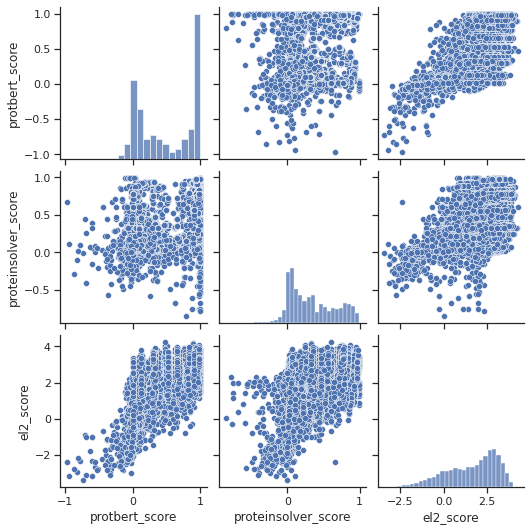

In [94]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(result_df[["protbert_score", "proteinsolver_score", "el2_score"]])

## Write results

In [95]:
output_dir = NOTEBOOK_DIR.joinpath("submission")
output_dir.mkdir(exist_ok=True)

output_dir

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/30_cagi6_hmbs/results')

In [96]:
%%file {output_dir}/strokach_desc.md
# Submission for CAGI6—HMBS challenge

## Overview

- `strokach_modelnumber_1.tsv` → Predictions made using ELASPIC2 [1].
- `strokach_modelnumber_2.tsv` → Predictions made using ProteinSolver [2].
- `strokach_modelnumber_3.tsv` → Predictions made using ProtBert [3].

## References

- [1] Strokach, A., Lu, T.Y., Kim, P.M., 2021. ELASPIC2 (EL2): Combining Contextualized Language Models and Graph Neural Networks to Predict Effects of Mutations. Journal of Molecular Biology, Computation Resources for Molecular Biology 433, 166810. https://doi.org/10.1016/j.jmb.2021.166810
- [2] Strokach, A., Becerra, D., Corbi-Verge, C., Perez-Riba, A., Kim, P.M., 2020. Fast and Flexible Protein Design Using Deep Graph Neural Networks. Cell Systems. https://doi.org/10.1016/j.cels.2020.08.016
- [3] Elnaggar, A., Heinzinger, M., Dallago, C., Rehawi, G., Wang, Y., Jones, L., Gibbs, T., Feher, T., Angerer, C., Steinegger, M., Bhowmik, D., Rost, B., 2020. ProtTrans: Towards Cracking the Language of Life’s Code Through Self-Supervised Deep Learning and High Performance Computing. bioRxiv 2020.07.12.199554. https://doi.org/10.1101/2020.07.12.199554

Overwriting /home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/30_cagi6_hmbs/results/strokach_desc.md


In [97]:
display(result_template_df.head(2))
len(result_template_df)

,aa_substitution,score,sd,comments
0,p.Ala112=,*,*,*
1,p.Ala112Arg,*,*,*


6894

In [98]:
result_df.head()

,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score
0,p.Ala112Arg,*,*,*,A112R,0.936811,0.809968,2.995820
1,p.Ala112Asn,*,*,*,A112N,0.936790,0.809852,3.083116
2,p.Ala112Asp,*,*,*,A112D,0.936767,0.810051,3.317553
3,p.Ala112Cys,*,*,*,A112C,0.911470,0.794887,1.254500
4,p.Ala112Gln,*,*,*,A112Q,0.936813,0.809917,3.161813


In [99]:
result_dfs = {}
for i, metric in enumerate(["el2", "proteinsolver", "protbert"]):
    result_dfs[metric] = result_template_df.merge(
        result_df, on=list(result_template_df.columns), how="left"
    )

    result_dfs[metric]["score"] = (
        1
        - result_dfs[metric][f"{metric}_score"].values / result_dfs[metric][f"{metric}_score"].max()
    )
    result_dfs[metric]["sd"] = 1.0
    result_dfs[metric]["comments"] = "*"

    result_dfs[metric].loc[result_dfs[metric]["aa_substitution"].str.endswith("="), "score"] = 0.0

    result_dfs[metric] = result_dfs[metric][
        ~result_dfs[metric]["aa_substitution"].str.contains("Ter", regex=False)
    ]

    print(metric)
    display(result_dfs[metric].head())

    output_file = output_dir.joinpath(f"strokach_modelnumber_{i + 1}.tsv")
    result_dfs[metric][result_template_df.columns].to_csv(output_file, sep="\t", index=False)
#     !python {NOTEBOOK_DIR}/validation.py {output_file}

el2


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score
0,p.Ala112=,0.000000,1.0,*,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.294013,1.0,*,A112R,0.936811,0.809968,2.995820
2,p.Ala112Asn,0.273442,1.0,*,A112N,0.936790,0.809852,3.083116
3,p.Ala112Asp,0.218195,1.0,*,A112D,0.936767,0.810051,3.317553
4,p.Ala112Cys,0.704368,1.0,*,A112C,0.911470,0.794887,1.254500


proteinsolver


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score
0,p.Ala112=,0.000000,1.0,*,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.183368,1.0,*,A112R,0.936811,0.809968,2.995820
2,p.Ala112Asn,0.183485,1.0,*,A112N,0.936790,0.809852,3.083116
3,p.Ala112Asp,0.183284,1.0,*,A112D,0.936767,0.810051,3.317553
4,p.Ala112Cys,0.198573,1.0,*,A112C,0.911470,0.794887,1.254500


protbert


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score
0,p.Ala112=,0.000000,1.0,*,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.062969,1.0,*,A112R,0.936811,0.809968,2.995820
2,p.Ala112Asn,0.062990,1.0,*,A112N,0.936790,0.809852,3.083116
3,p.Ala112Asp,0.063013,1.0,*,A112D,0.936767,0.810051,3.317553
4,p.Ala112Cys,0.088316,1.0,*,A112C,0.911470,0.794887,1.254500


el2 0.0
proteinsolver 0.0
protbert 0.0


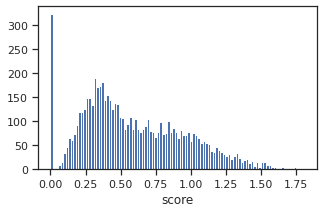

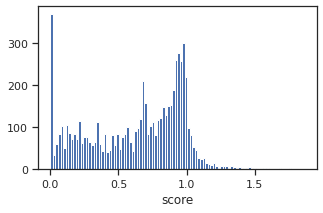

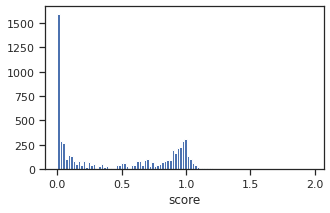

In [100]:
for metric, df in result_dfs.items():
    print(metric, df["score"].min())
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.hist(df["score"], bins=100)
    ax.set_xlabel("score")